In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.metrics import roc_auc_score
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [16]:
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
# print(df_sub.head())

In [17]:
print(df_sub.head())
print('\n')
print('----------------')
print(df_test.head())
print('\n')
print('----------------')
print(df_train)

       id  Exited
0  165034     0.5
1  165035     0.5
2  165036     0.5
3  165037     0.5
4  165038     0.5


----------------
       id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0  165034    15773898   Lucchese          586    France  Female  23.0       2   
1  165035    15782418       Nott          683    France  Female  46.0       2   
2  165036    15807120         K?          656    France  Female  34.0       7   
3  165037    15808905  O'Donnell          681    France    Male  36.0       8   
4  165038    15607314    Higgins          752   Germany    Male  38.0      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0       0.00              2        0.0             1.0        160976.75  
1       0.00              1        1.0             0.0         72549.27  
2       0.00              2        1.0             0.0        138882.09  
3       0.00              1        1.0             0.0        113931.57  
4  121263.62    

In [18]:
import numpy as np
import pandas as pd

def add_nulls(df, fraction=0.1):
    df = df.copy()
    num_cells = df.shape[0] * df.shape[1]
    num_nulls = int(num_cells * fraction)
    rows = np.random.randint(0, df.shape[0], num_nulls)
    cols = np.random.randint(0, df.shape[1], num_nulls)

    for row, col in zip(rows, cols):
        df.iat[row, col] = np.nan

    return df

def add_duplicates(df, fraction=0.1):
    df = df.copy()
    num_rows = int(len(df) * fraction)
    duplicate_rows = df.sample(num_rows, replace=True)
    return pd.concat([df, duplicate_rows], ignore_index=True)



In [19]:
df_sub = add_nulls(df_sub)
df_sub = add_duplicates(df_sub)

df_test = add_nulls(df_test)
df_test = add_duplicates(df_test)

df_train = add_nulls(df_train)
df_train = add_duplicates(df_train)

In [21]:
train_null = df_train.isnull().sum().sum()

test_null = df_test.isnull().sum().sum()

sub_null = df_sub.isnull().sum().sum()

print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {sub_null}')

Null Count in Train: 242045
Null Count in Test: 149888
Null Count in Submission: 23056


In [22]:

train_duplicates = df_train.duplicated().sum()
test_duplicates = df_test.duplicated().sum()
sub_duplicates = df_sub.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {sub_duplicates}")

Number of duplicate rows in train_data: 16503
Number of duplicate rows in test_data: 11002
Number of duplicate rows in test_data: 21476


In [23]:
# Remove rows with any null values
df_sub = df_sub.dropna()
df_test = df_test.dropna()
df_train = df_train.dropna()

# Remove duplicate rows
df_sub = df_sub.drop_duplicates()
df_test = df_test.drop_duplicates()
df_train = df_train.drop_duplicates()


In [24]:
train_null = df_train.isnull().sum().sum()

test_null = df_test.isnull().sum().sum()

sub_null = df_sub.isnull().sum().sum()

print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {sub_null}')

Null Count in Train: 0
Null Count in Test: 0
Null Count in Submission: 0


In [25]:
train_duplicates = df_train.duplicated().sum()
test_duplicates = df_test.duplicated().sum()
sub_duplicates = df_sub.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {sub_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in test_data: 0


In [29]:
num_col = df_train.select_dtypes(include=['number']).columns
print(num_col)

Index(['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


In [32]:
#Box Plot to find the outliers
num_col = df_train.select_dtypes(include=['number']).columns
num_plots = len(num_col)
cols = 2
rows = (num_plots // cols) + (num_plots % cols > 0)

fig = make_subplots(rows=rows, cols=cols)
fig.update_layout(plot_bgcolor="#764a23", paper_bgcolor="#E8CE9D")

for i, col in enumerate(num_col, start=1):
    row_num = (i - 1) // cols + 1
    col_num = (i - 1) % cols + 1
    fig.add_trace(
        go.Box(x=df_train[col], name=col, marker_color='#26090b', line_color='#26090b'),
        row=row_num,
        col=col_num
    )

fig.update_layout(title_text="Boxplots of Numerical Columns", showlegend=False)
fig.show()

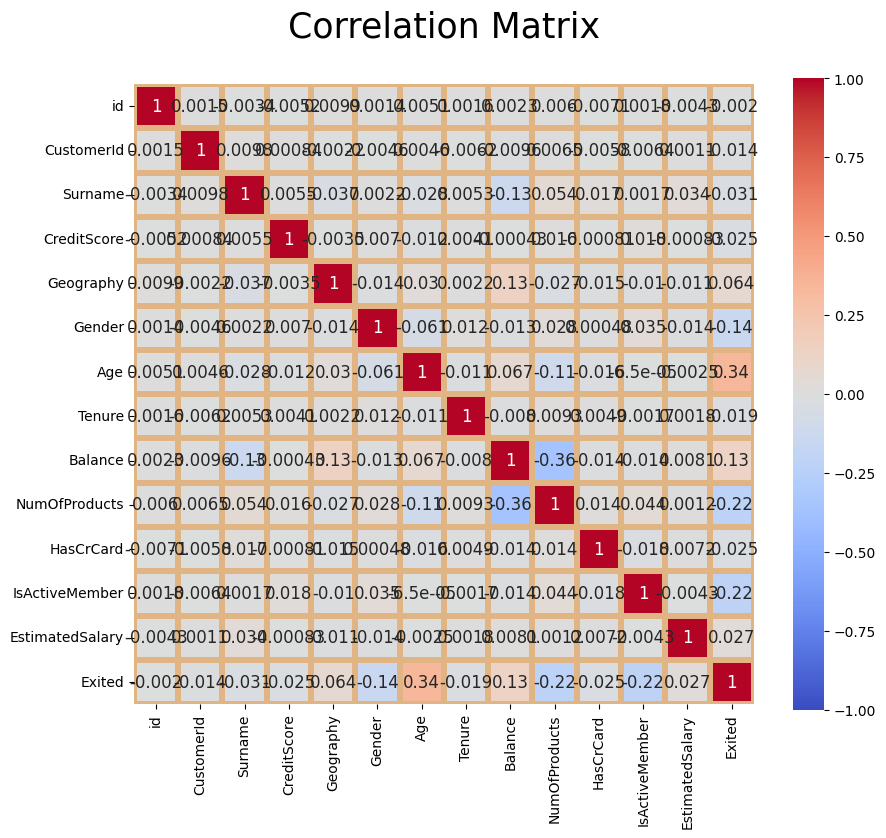

In [36]:

df_corr = df_train.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.subplots(figsize=(10, 10))

sns.heatmap(
    df_corr.corr(), 
    cmap="coolwarm", 
    square=True, 
    cbar_kws=dict(shrink=0.82),
    annot=True, 
    vmin=-1, 
    vmax=1, 
    linewidths=3, 
    linecolor='#e0b583', 
    annot_kws=dict(fontsize=12)
)
plt.title("Correlation Matrix\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



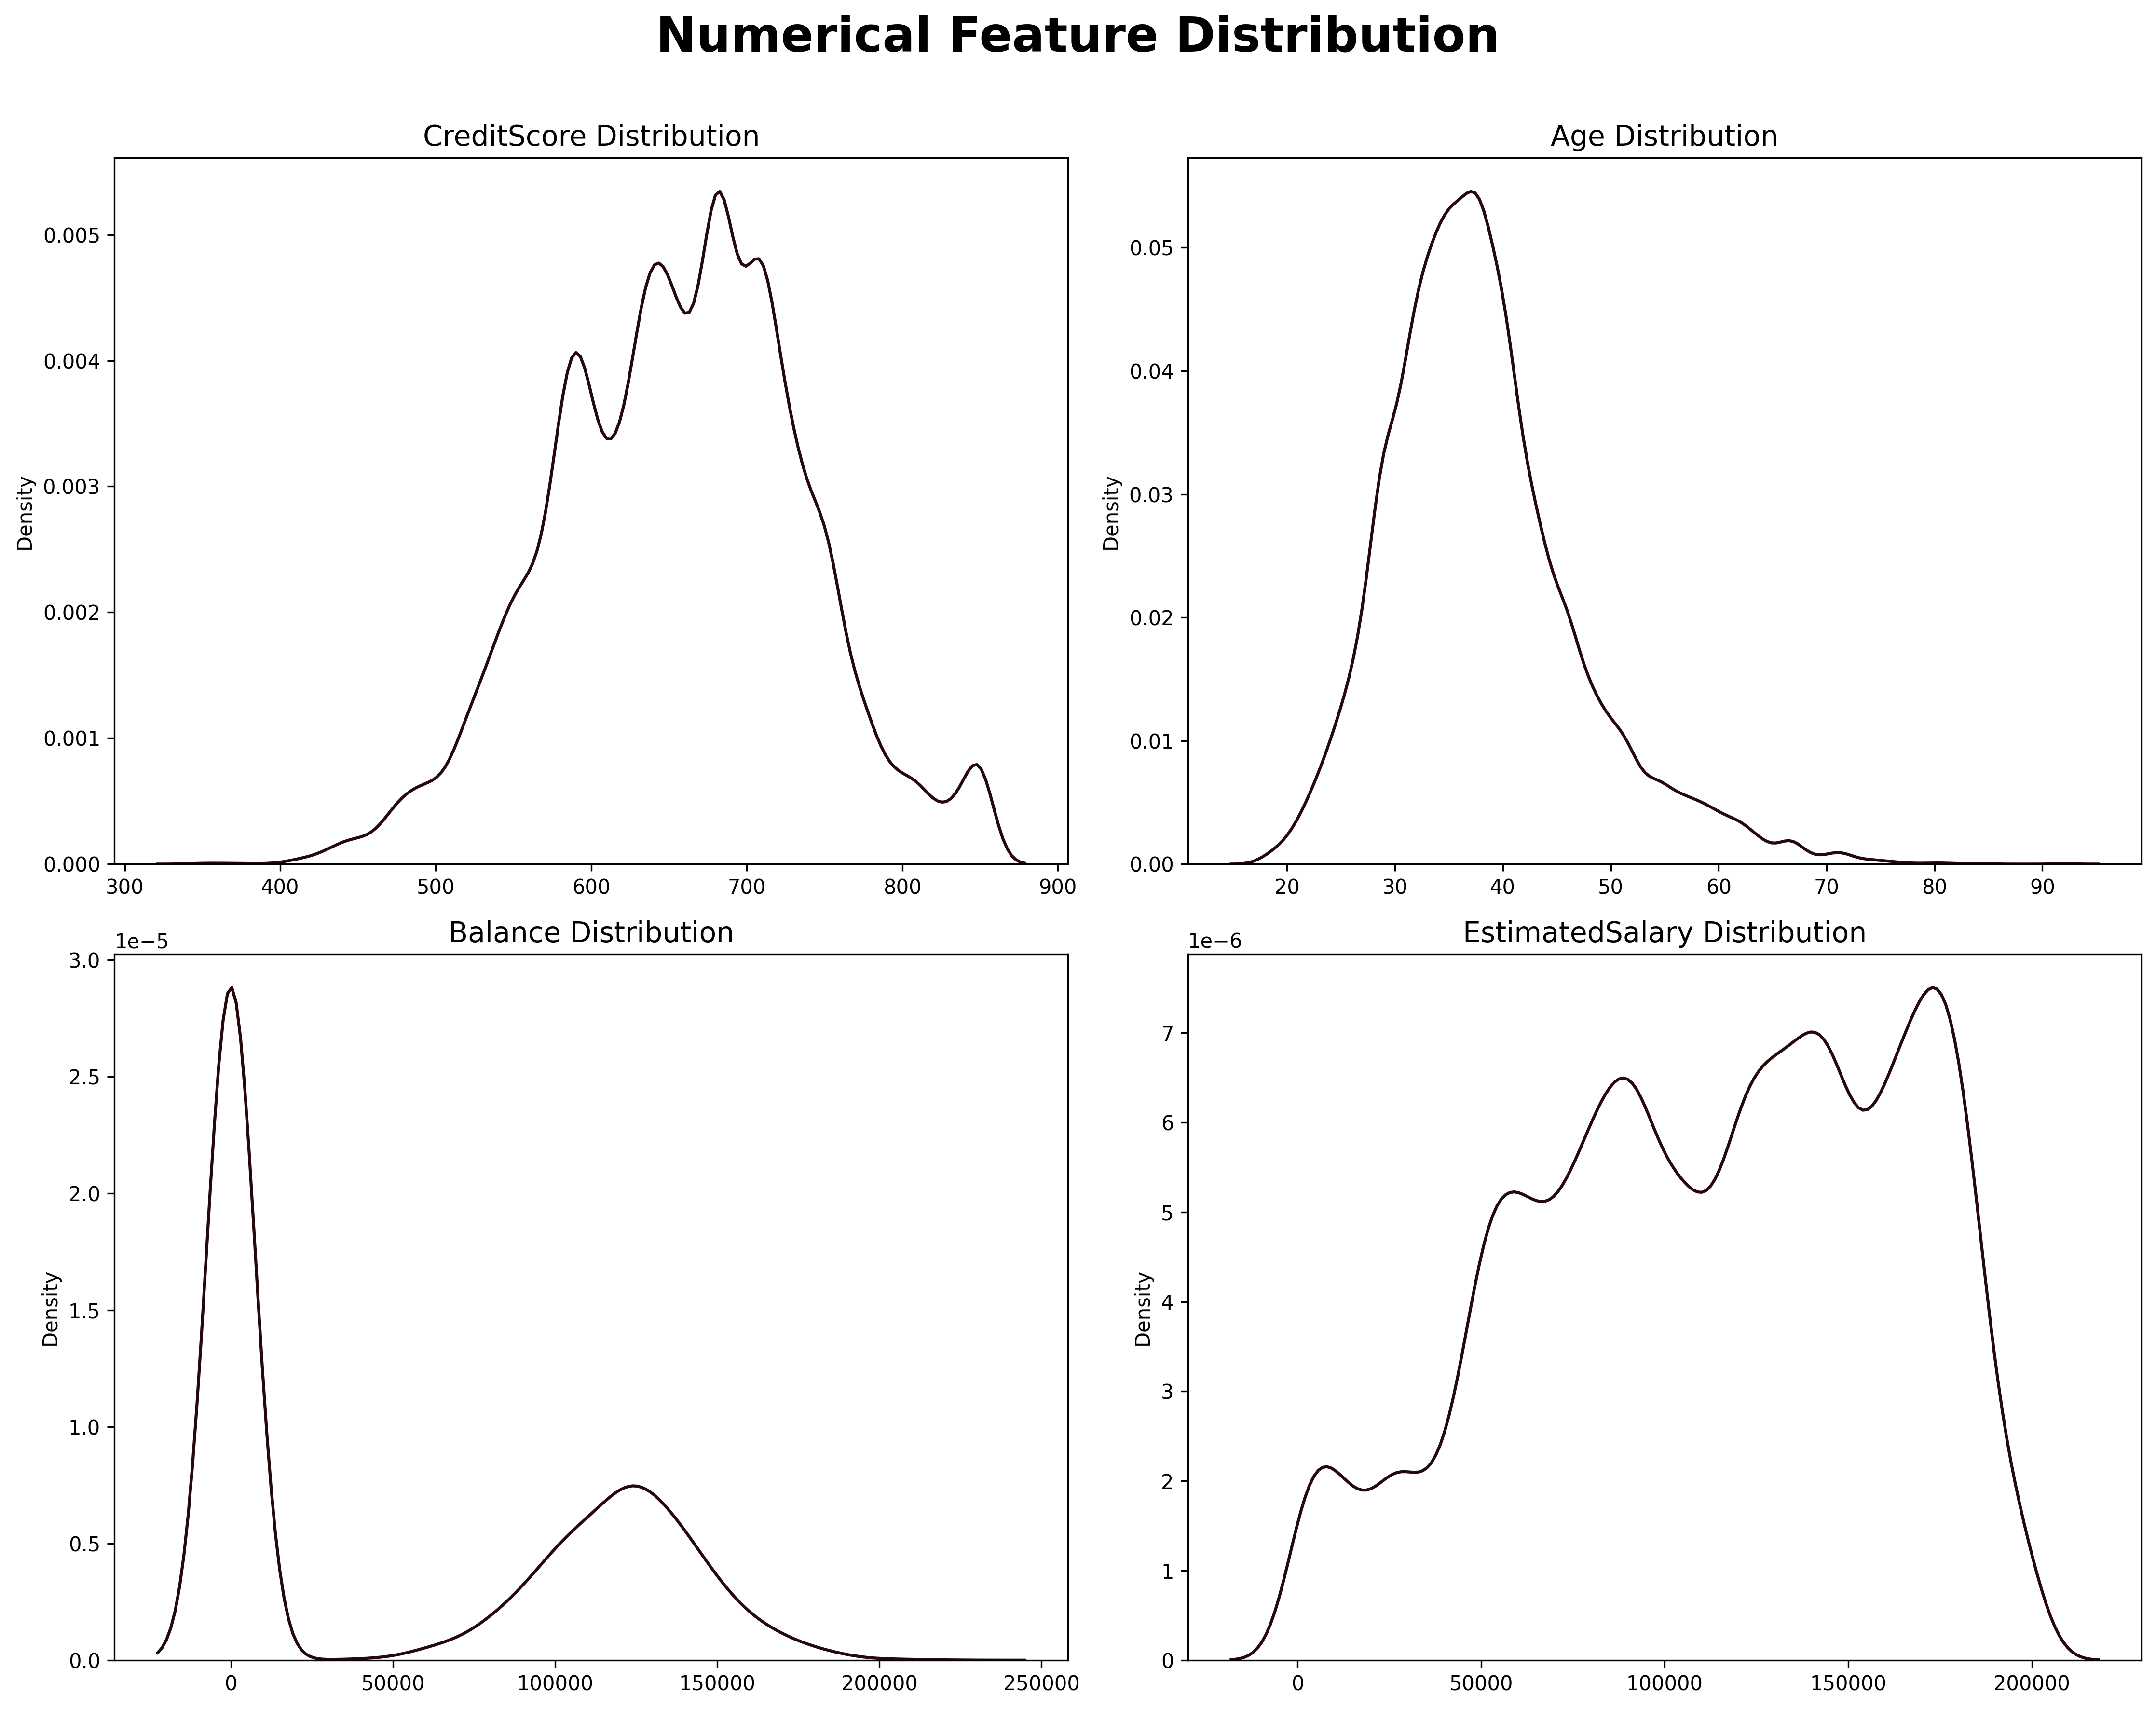

In [38]:
palette = sns.color_palette("coolwarm", n_colors=2)

fig, ax = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
ax = ax.flatten()

numerical_variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for i, column in enumerate(numerical_variables):
    sns.kdeplot(df_train[column], ax=ax[i], color='#26090b')        
    ax[i].set_title(f'{column} Distribution', size=14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Numerical Feature Distribution\n', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show()